In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_ML1M'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-1m'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pickle
from sklearn import metrics

In [3]:
[dftrain,dfvalid,results_concat]=pickle.load(open(f'{DATAPATH}/df_side_cold_runother.pkl','rb'))

In [4]:
df=pd.concat([dftrain,dfvalid[dftrain.columns]],axis=0)

In [5]:
user_to_idx={j:i+1 for i, j in enumerate(df['userId'].unique())}
item_to_idx={j:i+1 for i,j in enumerate(df['itemId'].unique())}
idx_to_user={i+1:j for i, j in enumerate(df['userId'].unique())}
idx_to_item={i+1:j for i,j in enumerate(df['itemId'].unique())}

In [6]:
dftrain['user_idx']=[user_to_idx[i] for i in dftrain['userId']]
dftrain['item_idx']=[item_to_idx[i] for i in dftrain['itemId']]

In [7]:
dfvalid['user_idx']=[user_to_idx[i] for i in dfvalid['userId']]
dfvalid['item_idx']=[item_to_idx[i] for i in dfvalid['itemId']]

In [8]:
pickle.dump([df, dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx],open(f'{DATAPATH}/reads.pkl','wb'))

### Dataset and DataLoader

In [9]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY):
        self.dfX,self.dfY=dfX,dfY
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.LongTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [10]:
dstrain=cfdata(dftrain[['user_idx','item_idx']],dftrain['rating'])
dsvalid=cfdata(dfvalid[['user_idx','item_idx']],dfvalid['rating'])

In [11]:
dftrain.shape

(895738, 392)

In [12]:
bs=256

In [13]:
dltrain=DataLoader(dstrain,bs,True)

In [14]:
dlvalid=DataLoader(dsvalid,bs,False)

In [15]:
len(user_to_idx),len(item_to_idx)

(6040, 3706)

## Model Architecture

In [16]:
n_users=len(user_to_idx)
n_items=len(item_to_idx)
n_emb_user=25
n_emb_item=25
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.05


In [17]:
n_users

6040

In [18]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e=0.01):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e=dropout_e
        self.create_architecture()
        self.init_parameters()
        self.criterion=nn.MSELoss()
        
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.emb_dropout=nn.Dropout(self.dropout_e)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)

        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.kaiming_normal_(self.ub.weight.data)
        nn.init.kaiming_normal_(self.ib.weight.data)

       
    def forward (self,Xb,Yb):               
        users=self.emb_dropout(self.emb_user(Xb[:,0]))
        items=self.emb_dropout(self.emb_item(Xb[:,1]))
        users_bias=self.emb_dropout(self.ub(Xb[:,0]))
        items_bias=self.emb_dropout(self.ib(Xb[:,1]))

        out=(users*items).sum(1)+users_bias.squeeze()+items_bias.squeeze()
        out=self.sigmoid(out)
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        preds=preds.view(-1,1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [19]:
n_users

6040

In [20]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)

In [21]:
cfobj

cf(
  (emb_user): Embedding(6041, 25)
  (emb_item): Embedding(3707, 25)
  (emb_dropout): Dropout(p=0.05)
  (ub): Embedding(6041, 1)
  (ib): Embedding(3707, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [22]:
for Xb, Yb in dltrain:
    break

In [23]:
Xb.shape, Yb.shape

(torch.Size([256, 2]), torch.Size([256, 1]))

In [24]:
cfobj.forward(Xb,Yb)

(tensor([[1.6082],
         [3.5201],
         [1.7333],
         [4.1014],
         [1.5196],
         [4.4286],
         [1.3910],
         [4.5381],
         [4.3984],
         [1.2335],
         [1.5470],
         [4.1372],
         [4.7964],
         [1.9882],
         [1.1252],
         [4.3497],
         [4.1965],
         [4.9632],
         [1.1435],
         [3.2922],
         [4.2917],
         [4.9181],
         [2.7995],
         [4.2474],
         [4.9072],
         [2.4770],
         [1.2167],
         [2.3572],
         [1.0047],
         [1.0723],
         [1.8734],
         [3.3562],
         [3.9159],
         [4.3706],
         [1.6933],
         [1.2412],
         [2.0546],
         [1.7686],
         [2.2506],
         [4.8838],
         [2.2671],
         [4.4249],
         [4.2322],
         [1.4249],
         [1.3309],
         [2.4737],
         [2.0268],
         [4.3322],
         [4.4702],
         [3.9499],
         [4.8324],
         [4.8154],
         [4.

## Learner

In [25]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=1.1,start_lr=2e-2, end_lr=5e-4,error_type="mse",
                cycle_const=False):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_const=cycle_const
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        self.scores=[]
        self.generate_scores=False
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

     
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
    
        
        with torch.no_grad():
            if self.error_type == "mse":
                acc=nn.L1Loss() (preds,Yb)
                myrmse=np.sqrt(myloss)
            else:
                acc=nn.MSELoss() (preds,Yb)
                myrmse=np.sqrt(acc.item())
            acc=acc.item()
                 
        if mode_train==False:
            if self.generate_scores:
                self.scores.append(preds.detach().cpu().numpy().flatten())
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss,acc,myrmse=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()

        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_rmse=epoch_rmse/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_rmse
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc,rmse=self.run_epoch(dltrain,True)

            lossv,accv,rmsev=self.run_epoch(dlvalid,mode_train=False)
           
            if self.error_type=="mse":
                loss_mse=loss
                loss_rmse=rmse
                loss_mae=acc
                lossv_mse=lossv
                lossv_rmse=rmsev
                lossv_mae=accv
                
            else:
                loss_mse=acc
                loss_rmse=rmse
                loss_mae=loss
                lossv_mse=accv
                lossv_rmse=rmsev
                lossv_mae=lossv
            
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} Train MSE:{loss_mse} Valid MSE:{lossv_mse} \
                Train MAE:{loss_mae} Valid MAE:{lossv_mae}')

              
         
     
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    self.wd=self.start_wd
                    if self.cycle_const == False:
                        self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                param_group['weight_decay']=self.wd
          
     

In [26]:
if 1==1:
    del cfobj
    torch.cuda.empty_cache()

In [27]:
device='cuda:1'

In [28]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)

In [29]:
cfobj=cfobj.to(device)

In [30]:
cfobj

cf(
  (emb_user): Embedding(6041, 25)
  (emb_item): Embedding(3707, 25)
  (emb_dropout): Dropout(p=0.05)
  (ub): Embedding(6041, 1)
  (ib): Embedding(3707, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [31]:
len(dltrain)

13996

In [32]:
wd=1e-4
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,5000,0.25,cycle_mult=0)

In [33]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

Batch:5000 3.1581169108867644  
Batch:10000 2.435188947188854  


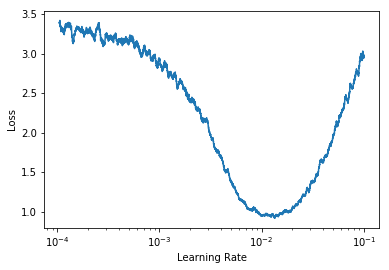

In [34]:
learner.plot_lrs(100)

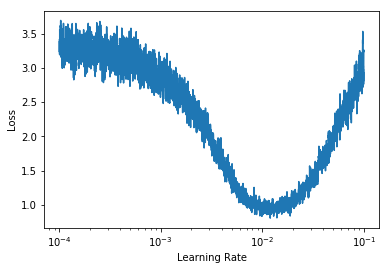

In [35]:
learner.plot_lrs(10)

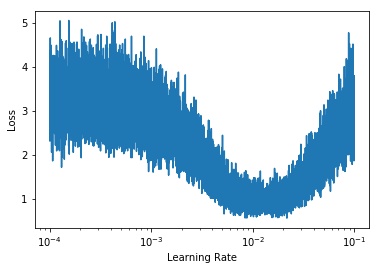

In [36]:
learner.plot_lrs(1)

In [95]:
del cfobj
torch.cuda.empty_cache()

In [28]:
wd=1e-5

In [29]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)
cfobj=cfobj.to(device)

In [30]:
device

'cuda:1'

In [31]:
cfobj

cf(
  (emb_user): Embedding(6041, 25)
  (emb_item): Embedding(3707, 25)
  (emb_dropout): Dropout(p=0.05)
  (ub): Embedding(6041, 1)
  (ib): Embedding(3707, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [32]:
optimizer=torch.optim.Adam(cfobj.parameters(),lr=1e-2,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,16000,0.25,cycle_mult=2,start_lr=1e-2,end_lr=5e-3,wd_mult=1.1)

In [33]:
learner.run_epochs(dltrain,dlvalid,3)

Epoch:0 Learning rate 0.01 Weight Decay 1e-05 Train Loss:1.1469859642347426                 Valid Loss:0.8966330361249686 Train RMSE:1.0515793624904415 Valid RMSE:0.9418269740464351 Train MSE:1.1469859642347426 Valid MSE:0.8966330361249686                 Train MAE:0.8325747221529433 Valid MAE:0.7474593240357844
Epoch:1 Learning rate 0.007071067811865476 Weight Decay 1.1000000000000001e-05 Train Loss:0.7750588797371399                 Valid Loss:0.8399436715762598 Train RMSE:0.8793273682640526 Valid RMSE:0.91104241060347 Train MSE:0.7750588797371399 Valid MSE:0.8399436715762598                 Train MAE:0.6944379289513419 Valid MAE:0.7241251910228309
Epoch:2 Learning rate 0.005000000000000001 Weight Decay 1.2100000000000003e-05 Train Loss:0.7093292594160411                 Valid Loss:0.8166759990538245 Train RMSE:0.8411688311242924 Valid RMSE:0.8982445452916441 Train MSE:0.7093292594160411 Valid MSE:0.8166759990538245                 Train MAE:0.6660679495992167 Valid MAE:0.71478034508

In [34]:
learner.lr

0.01

In [38]:
learner.start_lr=6e-3
learner.lr=6e-3
for param in optimizer.param_groups:
    param['lr']=6e-3

In [39]:
learner.end_lr

0.005

In [40]:
learner.run_epochs(dltrain,dlvalid,3)

Epoch:0 Learning rate 0.006 Weight Decay 1e-05 Train Loss:0.7098135245582246                 Valid Loss:0.8274575520698482 Train RMSE:0.8412953749441258 Valid RMSE:0.9043428771921399 Train MSE:0.7098135245582246 Valid MSE:0.8274575520698482                 Train MAE:0.6657072000416322 Valid MAE:0.7180116879036491
Epoch:1 Learning rate 0.005732656753226201 Weight Decay 1.1000000000000001e-05 Train Loss:0.6947250033436791                 Valid Loss:0.8246012972007463 Train RMSE:0.8322871029313195 Valid RMSE:0.9026641536908792 Train MSE:0.6947250033436791 Valid MSE:0.8246012972007463                 Train MAE:0.6584518935449398 Valid MAE:0.7175734685802226
Epoch:2 Learning rate 0.005477225575051661 Weight Decay 1.2100000000000003e-05 Train Loss:0.6866912611401671                 Valid Loss:0.8187297361841411 Train RMSE:0.8274502117030956 Valid RMSE:0.8992821650073012 Train MSE:0.6866912611401671 Valid MSE:0.8187297361841411                 Train MAE:0.6551546608423907 Valid MAE:0.71515398

In [41]:
learner.generate_scores=True

In [42]:
learner.run_epoch(dlvalid,False)

(0.8187297361841411, 0.7151539872211465, 0.8992821650073012)

In [43]:
np.concatenate(learner.scores)

array([3.3770335, 3.7116957, 3.735203 , ..., 2.1500933, 1.9759055,
       2.4840913], dtype=float32)

In [44]:
dfvalid['pred_cf']=np.concatenate(learner.scores)

In [45]:
np.sqrt(metrics.mean_squared_error(dfvalid['rating'],dfvalid['pred_cf']))

0.9048717958409898

In [48]:
def score_by_group (dfvalid,predVar,groupVar='cold_start_group',method='global_avg'):
    scores=[]
    mae_scores=[]
    rmse_scores=[]
    r2_scores=[]
    groups=dfvalid[groupVar].value_counts().index.tolist()
    for group in groups:
        df=dfvalid.loc[dfvalid[groupVar]==group]
        actual=df['rating']
        score=metrics.mean_squared_error(df['rating'],df[predVar])
        rmse_score=np.sqrt(metrics.mean_squared_error(df['rating'],df[predVar]))
        mae_score=metrics.mean_absolute_error(df['rating'],df[predVar])
        r2_score=metrics.r2_score(df['rating'],df[predVar])
        scores.append(score)
        mae_scores.append(mae_score)
        rmse_scores.append(rmse_score)
        r2_scores.append(r2_score)
    return pd.DataFrame({'method':method, 'mse':scores, 'rmse':rmse_scores, 'mae':mae_scores, 'r2_score':r2_scores, 'Cold Start Group':groups})

In [49]:
result_cf=pd.concat([score_by_group(dfvalid,'pred_cf','cold_start_group','cf'),score_by_group(dfvalid,'pred_cf','cold_start_bucket','cf'),\
score_by_group(dfvalid,'pred_cf','flag_train','cf')],axis=0)
result_cf

,method,mse,rmse,mae,r2_score,Cold Start Group
0,cf,0.794892,0.891567,0.701948,0.394846,No-cold-start
1,cf,1.065046,1.032011,0.850611,0.109225,User-Cold-Start
2,cf,0.724512,0.851183,0.704314,0.130586,Item-Cold_start
3,cf,2.000000,1.414214,1.000000,-1.000000,User-Item-cold-start
0,cf,0.794892,0.891567,0.701948,0.394846,0
1,cf,1.064366,1.031681,0.850264,0.109881,1
0,cf,0.818793,0.904872,0.715103,0.373547,0


In [50]:
mtx_user_emb=cfobj.emb_user.weight.data.cpu().numpy()
mtx_item_emb=cfobj.emb_item.weight.data.cpu().numpy()

In [51]:
user_bias_emb=cfobj.ub.weight.data.cpu().numpy()
item_bias_emb=cfobj.ib.weight.data.cpu().numpy()

In [52]:
mtx_user_emb.shape, mtx_item_emb.shape, user_bias_emb.shape, item_bias_emb.shape

((6041, 25), (3707, 25), (6041, 1), (3707, 1))

In [53]:
pickle.dump([mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb],open(f'{DATAPATH}/wts_embs','wb'))

In [54]:
results_concat.shape

(70, 6)

In [55]:
results_concat=pd.concat([results_concat,result_cf],axis=0)

In [56]:
pickle.dump([df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat],open(f'{DATAPATH}/df_side_cold_runother_cf.pkl','wb'))

In [57]:
results_concat[:40]

,method,mse,rmse,mae,r2_score,Cold Start Group
0,biasedmatrixfactorization,0.762661,0.873305,0.686658,0.419384,No-cold-start
1,biasedmatrixfactorization,0.975590,0.987719,0.787813,0.184044,User-Cold-Start
2,biasedmatrixfactorization,1.004593,1.002294,0.866920,-0.205512,Item-Cold_start
3,biasedmatrixfactorization,1.161611,1.077781,1.000000,-0.161611,User-Item-cold-start
0,biasedmatrixfactorization,0.762661,0.873305,0.686658,0.419384,0
1,biasedmatrixfactorization,0.975705,0.987778,0.788064,0.184027,1
0,biasedmatrixfactorization,0.781557,0.884057,0.695652,0.402036,0
0,svdplusplus,0.760565,0.872104,0.681210,0.420979,No-cold-start
1,svdplusplus,0.965663,0.982682,0.789363,0.192346,User-Cold-Start
2,svdplusplus,1.005146,1.002569,0.877412,-0.206175,Item-Cold_start


In [58]:
results_concat[40:]

,method,mse,rmse,mae,r2_score,Cold Start Group
1,itemknnpearson,0.968187,0.983965,0.787255,0.190315,1
0,itemknnpearson,0.817426,0.904116,0.707335,0.374592,0
0,itemknncosine,0.813202,0.901777,0.706219,0.380906,No-cold-start
1,itemknncosine,0.968217,0.983980,0.787066,0.190210,User-Cold-Start
2,itemknncosine,0.940441,0.969763,0.842502,-0.128529,Item-Cold_start
3,itemknncosine,1.161611,1.077781,1.000000,-0.161611,User-Item-cold-start
0,itemknncosine,0.813202,0.901777,0.706219,0.380906,0
1,itemknncosine,0.968187,0.983965,0.787255,0.190315,1
0,itemknncosine,0.826949,0.909367,0.713406,0.367307,0
0,itemavg,0.986194,0.993073,0.789912,0.249207,No-cold-start
